# Day 5: Regularized Linear Regression and Bias v.s. Variance

In this exercise, you will implement regularized linear regression and use it to study models with different bias-variance properties.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 5)
import scipy.io # Used to load the OCTAVE *.mat files
import scipy.optimize # To call fmin_cf to train the linear regression
import warnings
warnings.filterwarnings('ignore')

## 1 Regularized Linear Regression

In the first half of the exercise, you will implement regularized linear regression to predict the amount of water flowing out of a dam using the change of water level in a reservoir. In the next half, you will go through some diagnostics of debugging learning algorithms and examine the effects of bias v.s. variance.

### 1.1 Visualizing the dataset

In [2]:
data = scipy.io.loadmat('data/ex5data1.mat')
X = np.c_[np.ones((data['X'].shape[0], 1)), data['X']]
y = np.c_[data['y']]
X_val = np.c_[np.ones((data['Xval'].shape[0], 1)), data['Xval']]
y_val = np.c_[data['yval']]
X_test = np.c_[np.ones((data['Xtest'].shape[0], 1)), data['Xtest']]
y_test = np.c_[data['ytest']]
print('Shape of X, y:', X.shape, y.shape)
print('Shape of X_val, y_val:', X_test.shape, y_test.shape)
print('Shape of X_test, y_test:', X_test.shape, y_test.shape)

Shape of X, y: (12, 2) (12, 1)
Shape of X_val, y_val: (21, 2) (21, 1)
Shape of X_test, y_test: (21, 2) (21, 1)


In [3]:
def plotData():
    plt.plot(X[:, 1], y, 'rx')
    plt.xlabel('Change in water level (x)')
    plt.ylabel('Water flowing out of the dam (y)')

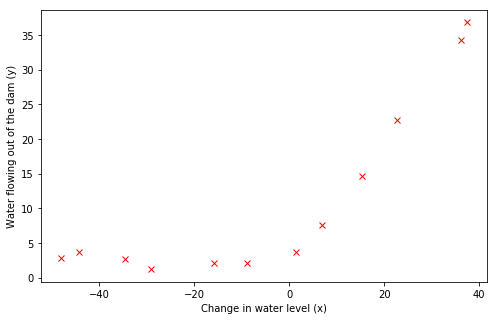

In [4]:
plotData()

### 1.2 Regularized linear regression cost function

Recall that regularized linear regression has the following cost function:

$$J(\theta) = \frac{1}{2m} \left(\sum_{i=1}^{m}(h_\theta(x^{(i)}) - y^{(i)})^2\right) + \frac{\lambda}{2m} \left(\sum_{j=1}^n\theta_j^2\right)$$

where $\lambda$ is a regularization parameter which controls the degree of regularization (thus, help preventing overfitting).

In [5]:
def h(theta,X): #Linear hypothesis function
    return np.dot(X,theta)

def computeCost(theta, X, y,lambd=0.): #Cost function
    """
    theta_start is an n- dimensional vector of initial theta guess
    X is matrix with n- columns and m- rows
    y is a matrix with m- rows and 1 column
    """
    m = X.shape[0]
    myh = h(theta,X).reshape((m,1))
    cost = float((1./(2*m)) * np.dot((myh-y).T,(myh-y)))
    reg = (float(lambd)/(2*m)) * float(theta[1:].T.dot(theta[1:]))
    return cost + reg

In [6]:
# Using theta initialized at [1;1] and lambda=1, you should expect
# to see an output of 303.993
theta = np.array([[1.], [1.]])
print(computeCost(theta, X, y, lambd=1.))

303.9931922202643


### 1.3 Regularized linear regression gradient

Correspondingly, the partial derivative of regularized linear regression’s cost for $\theta_j$ is defined as
$$\frac{\partial J(\theta)}{\partial\theta_0} = \frac{1}{m}\sum_{i=1}^m (h_{\theta}(x^{(i)}) - y^{(i)}) x_j^{(i)} \hspace{10mm} for \hspace{3mm} j = 0$$
$$\frac{\partial J(\theta)}{\partial\theta_j} = \left(\frac{1}{m}\sum_{i=1}^m (h_{\theta}(x^{(i)}) - y^{(i)}) x_j^{(i)} \right) + \frac{\lambda}{m} \theta_j \hspace{10mm} for \hspace{3mm} j \geq 1$$

In [7]:
def computeGradient(theta, X, y, lambd=0.):
    '''Implement compute the linear gression gradient.
    Parameters:
        theta: parameters of the model, which is an n-vector
        X: training set, which is matrix with m-rows and n-columns 
        y: target set, which is a matrix with m-rows and 1-columns
        lambd: regularization parameter, default = 0'''
    theta = theta.reshape((theta.shape[0],1))
    m = X.shape[0]
    grad = (1./float(m))* X.T.dot(h(theta,X)-y)
    reg = (float(lambd)/m)*theta
    reg[0] = 0 #don't regulate bias term
    reg.reshape((grad.shape[0],1))
    return grad + reg

# This is for the minimization routine that wants everything flattened
def computeGradientFlattened(theta, X, y, lambd=0.):
    return computeGradient(theta, X, y, lambd=0.).flatten()

In [8]:
# Using theta initialized at [1; 1] you should expect to see a
# gradient of [-15.303016; 598.250744] (with lambda=1)
theta = np.array([[1.], [1.]])
print(computeGradient(theta, X, y, 1.))

[[ -15.30301567]
 [ 598.25074417]]


### 1.4 Fitting linear regression

In [9]:
def optimizeTheta(theta_initial, X, y, lambd=0., print_output=True):
    fit_theta = scipy.optimize.fmin_cg(computeCost, x0=theta_initial,
                                       fprime=computeGradientFlattened,
                                       args=(X, y, lambd),
                                       disp=print_output,
                                       epsilon=1.49e-12,
                                       maxiter=1000)
    fit_theta = fit_theta.reshape((theta_initial.shape[0], 1))
    return fit_theta

In [10]:
theta_initial = np.array([[1.], [1.]])
fit_theta = optimizeTheta(theta_initial, X, y, 0.)

Optimization terminated successfully.
         Current function value: 22.373906
         Iterations: 18
         Function evaluations: 28
         Gradient evaluations: 28


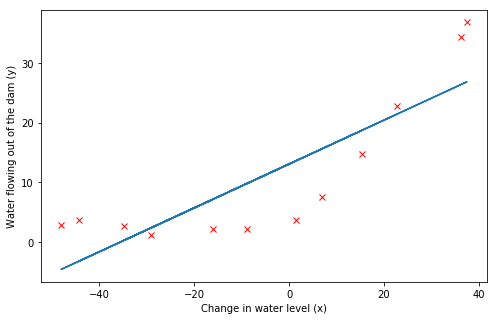

In [11]:
plotData()
plt.plot(X[:, 1], np.dot(X, fit_theta).flatten());

## 2 Bias-variance

An important concept in machine learning is the bias-variance tradeoff. Models with high bias are not complex enough for the data and tend to underfit, while models with high variance overfit to the training data.

In this part of the exercise, you will plot training and test errors on a learning curve to diagnose bias-variance problems.

### 2.1 Learning curves

You will now implement code to generate the learning curves that will be useful in debugging learning algorithms. Recall that a learning curve plots training and cross validation error as a function of training set size. 

In [12]:
def plotLearningCurve():
    """
    Loop over first training point, then first 2 training points, then first 3 ...
    and use each training-set-subset to find trained parameters.
    With those parameters, compute the cost on that subset (Jtrain)
    remembering that for Jtrain, lambda = 0 (even if you are using regularization).
    Then, use the trained parameters to compute Jval on the entire validation set
    again forcing lambda = 0 even if using regularization.
    Store the computed errors, error_train and error_val and plot them.
    """
    initial_theta = np.array([[1.], [1.]])
    m, error_train, error_val = [], [], []
    for x in range(1, 13):
        train_subset = X[:x, :]
        y_subset = y[:x]
        m.append(y_subset.shape[0])
        fit_theta = optimizeTheta(initial_theta, train_subset, y_subset, lambd=0., print_output=False)
        error_train.append(computeCost(fit_theta, train_subset, y_subset, lambd=0.))
        error_val.append(computeCost(fit_theta, X_val, y_val, lambd=0.))

    plt.plot(m, error_train, label='Train', c='b')
    plt.plot(m, error_val, label='Cross Validation', c='g')
    plt.legend(loc=1)
    plt.title('Learning curve for linear regression')
    plt.xlabel('Number of training examples')
    plt.ylabel('Error')

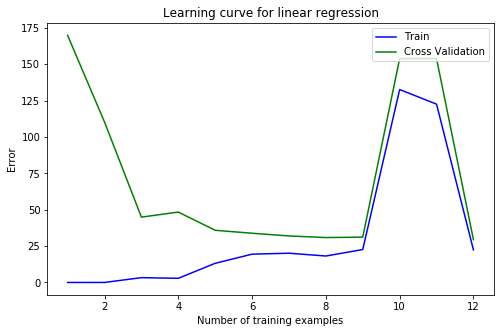

In [13]:
plotLearningCurve()

**WRONG !!**